# 6. 학습 관련 기술들

## 6.1. 매개변수 갱신

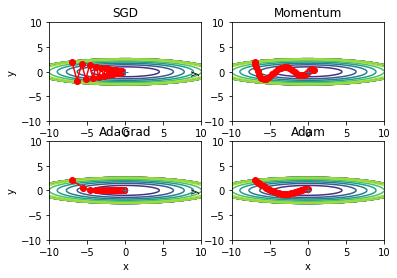

In [4]:
import sys, os
os.chdir("C:/Users/Soyeon/Desktop/Study/DL-Study/밑시딥/deep-learning-from-scratch/ch06/")
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()


#### MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.339134382984735
Momentum:2.3742226733501326
AdaGrad:2.476981003771246
Adam:2.280325557617153
===========iteration:100===========
SGD:1.7477975489095554
Momentum:0.3091271046788065
AdaGrad:0.14086083461931898
Adam:0.19916365345700712
===========iteration:200===========
SGD:0.9229333552528145
Momentum:0.21707225213435463
AdaGrad:0.07518051136517367
Adam:0.17541902188615754
===========iteration:300===========
SGD:0.7245855696314671
Momentum:0.172068138135887
AdaGrad:0.0772940477763315
Adam:0.10719021473182921
===========iteration:400===========
SGD:0.5303684401304467
Momentum:0.13154667931531797
AdaGrad:0.051596534771124025
Adam:0.1040327467231049
===========iteration:500===========
SGD:0.40230684771312486
Momentum:0.18372044556709868
AdaGrad:0.0700141423409692
Adam:0.11224261085460174
===========iteration:600===========
SGD:0.4244399939133327
Momentum:0.16293579566803526
AdaGrad:0.06489025026236045
Adam:0.10685640219098963
===========iteration:700=

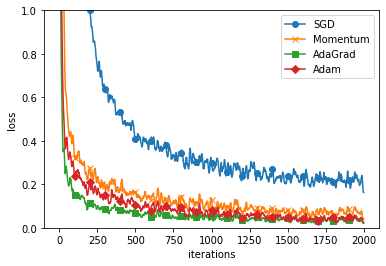

In [5]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


## 6.2. 가중치의 초깃값

* 초깃값을 모두 0으로 해버리면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문에 초깃값을 **무작위로** 설정해야 한다.

은닉층의 활성화값 분포를 확인해보자.

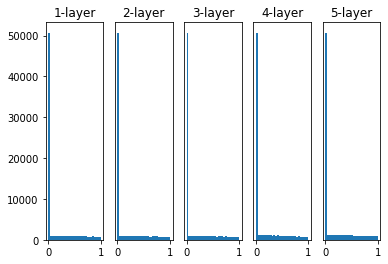

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
#     w = np.random.randn(node_num, node_num) * 1
#     w = np.random.randn(node_num, node_num) * 0.01
#     w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)  # Xavier 초기갓값
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)  # He 초깃값


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
#     z = sigmoid(a)
    z = ReLU(a)
#     z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

#### MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.30245923074564
Xavier:2.3097729907394973
He:2.390590463302206
===========iteration:100===========
std=0.01:2.301970301592637
Xavier:2.2622816204776393
He:1.4985632404603932
===========iteration:200===========
std=0.01:2.3007034734380354
Xavier:2.1863441447643743
He:0.7504624306116416
===========iteration:300===========
std=0.01:2.3015950223995354
Xavier:1.9868370144376808
He:0.5685975524994216
===========iteration:400===========
std=0.01:2.3009009215149785
Xavier:1.4991762382307479
He:0.36841135051420104
===========iteration:500===========
std=0.01:2.304350889378512
Xavier:1.146443316548293
He:0.42203921364848274
===========iteration:600===========
std=0.01:2.3005965687808523
Xavier:0.7092416334202953
He:0.2850767970873374
===========iteration:700===========
std=0.01:2.3043146007704083
Xavier:0.5532180523782662
He:0.2826911363601755
===========iteration:800===========
std=0.01:2.3061790960973654
Xavier:0.5995948016618118
He:0.237644899672713

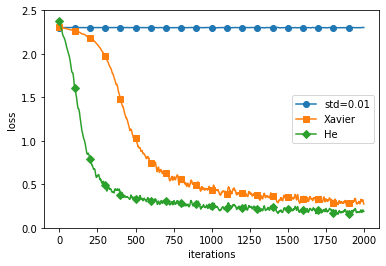

In [14]:
import os
import sys

os.chdir("C:/Users/Soyeon/Desktop/Study/DL-Study/밑시딥/deep-learning-from-scratch/ch06/")
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3. 배치 정규화(Batch Nomalization)

#### 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.099 - 0.075


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.086
epoch:2 | 0.097 - 0.124
epoch:3 | 0.097 - 0.148
epoch:4 | 0.097 - 0.174
epoch:5 | 0.097 - 0.194
epoch:6 | 0.097 - 0.223
epoch:7 | 0.097 - 0.253
epoch:8 | 0.097 - 0.276
epoch:9 | 0.097 - 0.315
epoch:10 | 0.097 - 0.318
epoch:11 | 0.097 - 0.34
epoch:12 | 0.097 - 0.35
epoch:13 | 0.097 - 0.38
epoch:14 | 0.097 - 0.396
epoch:15 | 0.097 - 0.409
epoch:16 | 0.097 - 0.414
epoch:17 | 0.097 - 0.429
epoch:18 | 0.097 - 0.436


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.464
============== 2/16 ==============
epoch:0 | 0.094 - 0.104


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\users\soyeon\python2021\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.108
epoch:2 | 0.097 - 0.13
epoch:3 | 0.097 - 0.133
epoch:4 | 0.097 - 0.153
epoch:5 | 0.097 - 0.171
epoch:6 | 0.097 - 0.2
epoch:7 | 0.097 - 0.214
epoch:8 | 0.097 - 0.239
epoch:9 | 0.097 - 0.257
epoch:10 | 0.097 - 0.282
epoch:11 | 0.097 - 0.312
epoch:12 | 0.097 - 0.318
epoch:13 | 0.097 - 0.331
epoch:14 | 0.097 - 0.344
epoch:15 | 0.097 - 0.366
epoch:16 | 0.097 - 0.384
epoch:17 | 0.097 - 0.402
epoch:18 | 0.097 - 0.428


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.435
============== 3/16 ==============
epoch:0 | 0.117 - 0.091
epoch:1 | 0.401 - 0.11
epoch:2 | 0.528 - 0.174
epoch:3 | 0.619 - 0.215
epoch:4 | 0.659 - 0.248
epoch:5 | 0.718 - 0.287
epoch:6 | 0.765 - 0.328
epoch:7 | 0.79 - 0.361
epoch:8 | 0.831 - 0.391
epoch:9 | 0.868 - 0.429
epoch:10 | 0.888 - 0.456
epoch:11 | 0.898 - 0.483
epoch:12 | 0.922 - 0.509
epoch:13 | 0.933 - 0.532
epoch:14 | 0.939 - 0.551
epoch:15 | 0.953 - 0.573
epoch:16 | 0.961 - 0.596
epoch:17 | 0.964 - 0.614
epoch:18 | 0.97 - 0.626


No handles with labels found to put in legend.


epoch:19 | 0.972 - 0.64
============== 4/16 ==============
epoch:0 | 0.106 - 0.107
epoch:1 | 0.21 - 0.118
epoch:2 | 0.3 - 0.222
epoch:3 | 0.413 - 0.289
epoch:4 | 0.498 - 0.363
epoch:5 | 0.552 - 0.417
epoch:6 | 0.603 - 0.472
epoch:7 | 0.65 - 0.537
epoch:8 | 0.658 - 0.57
epoch:9 | 0.694 - 0.608
epoch:10 | 0.721 - 0.645
epoch:11 | 0.749 - 0.685
epoch:12 | 0.772 - 0.707
epoch:13 | 0.78 - 0.73
epoch:14 | 0.798 - 0.738
epoch:15 | 0.812 - 0.768
epoch:16 | 0.813 - 0.778
epoch:17 | 0.815 - 0.789
epoch:18 | 0.826 - 0.797


No handles with labels found to put in legend.


epoch:19 | 0.839 - 0.808
============== 5/16 ==============
epoch:0 | 0.072 - 0.11
epoch:1 | 0.079 - 0.174
epoch:2 | 0.092 - 0.288
epoch:3 | 0.101 - 0.42
epoch:4 | 0.113 - 0.525
epoch:5 | 0.125 - 0.604
epoch:6 | 0.147 - 0.648
epoch:7 | 0.152 - 0.684
epoch:8 | 0.161 - 0.719
epoch:9 | 0.17 - 0.738
epoch:10 | 0.17 - 0.757
epoch:11 | 0.174 - 0.776
epoch:12 | 0.18 - 0.796
epoch:13 | 0.199 - 0.804
epoch:14 | 0.207 - 0.82
epoch:15 | 0.203 - 0.833
epoch:16 | 0.204 - 0.847
epoch:17 | 0.197 - 0.861
epoch:18 | 0.196 - 0.868


No handles with labels found to put in legend.


epoch:19 | 0.204 - 0.879
============== 6/16 ==============
epoch:0 | 0.131 - 0.146
epoch:1 | 0.134 - 0.261
epoch:2 | 0.158 - 0.444
epoch:3 | 0.162 - 0.576
epoch:4 | 0.157 - 0.675
epoch:5 | 0.159 - 0.721
epoch:6 | 0.171 - 0.752
epoch:7 | 0.142 - 0.791
epoch:8 | 0.117 - 0.813
epoch:9 | 0.117 - 0.832
epoch:10 | 0.117 - 0.849
epoch:11 | 0.117 - 0.876
epoch:12 | 0.117 - 0.89
epoch:13 | 0.117 - 0.894
epoch:14 | 0.117 - 0.912
epoch:15 | 0.117 - 0.916
epoch:16 | 0.117 - 0.919
epoch:17 | 0.117 - 0.925
epoch:18 | 0.117 - 0.932


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.941
============== 7/16 ==============
epoch:0 | 0.117 - 0.116
epoch:1 | 0.117 - 0.255
epoch:2 | 0.116 - 0.554
epoch:3 | 0.116 - 0.647
epoch:4 | 0.117 - 0.7
epoch:5 | 0.117 - 0.726
epoch:6 | 0.117 - 0.752
epoch:7 | 0.117 - 0.786
epoch:8 | 0.117 - 0.829
epoch:9 | 0.117 - 0.871
epoch:10 | 0.116 - 0.889
epoch:11 | 0.117 - 0.916
epoch:12 | 0.117 - 0.933
epoch:13 | 0.117 - 0.941
epoch:14 | 0.117 - 0.96
epoch:15 | 0.117 - 0.963
epoch:16 | 0.117 - 0.972
epoch:17 | 0.117 - 0.98
epoch:18 | 0.117 - 0.983


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.985
============== 8/16 ==============
epoch:0 | 0.116 - 0.111
epoch:1 | 0.116 - 0.302
epoch:2 | 0.116 - 0.692
epoch:3 | 0.116 - 0.775
epoch:4 | 0.116 - 0.807
epoch:5 | 0.116 - 0.847
epoch:6 | 0.116 - 0.873
epoch:7 | 0.116 - 0.913
epoch:8 | 0.116 - 0.937
epoch:9 | 0.116 - 0.962
epoch:10 | 0.116 - 0.981
epoch:11 | 0.116 - 0.984
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.995
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 9/16 ==============
epoch:0 | 0.093 - 0.102
epoch:1 | 0.116 - 0.536
epoch:2 | 0.116 - 0.731
epoch:3 | 0.116 - 0.839
epoch:4 | 0.116 - 0.901
epoch:5 | 0.116 - 0.948
epoch:6 | 0.116 - 0.96
epoch:7 | 0.116 - 0.98
epoch:8 | 0.116 - 0.988
epoch:9 | 0.116 - 0.991
epoch:10 | 0.116 - 0.994
epoch:11 | 0.117 - 0.997
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.997
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.099 - 0.125
epoch:1 | 0.116 - 0.598
epoch:2 | 0.116 - 0.75
epoch:3 | 0.117 - 0.773
epoch:4 | 0.117 - 0.801
epoch:5 | 0.116 - 0.82
epoch:6 | 0.117 - 0.877
epoch:7 | 0.117 - 0.883
epoch:8 | 0.117 - 0.957
epoch:9 | 0.117 - 0.979
epoch:10 | 0.117 - 0.978
epoch:11 | 0.117 - 0.986
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.996


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.099 - 0.213
epoch:1 | 0.105 - 0.677
epoch:2 | 0.117 - 0.73
epoch:3 | 0.105 - 0.232
epoch:4 | 0.105 - 0.867
epoch:5 | 0.105 - 0.887
epoch:6 | 0.117 - 0.942
epoch:7 | 0.117 - 0.957
epoch:8 | 0.117 - 0.932
epoch:9 | 0.117 - 0.974
epoch:10 | 0.116 - 0.972
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.991
epoch:15 | 0.116 - 0.993
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.994
epoch:18 | 0.117 - 0.995


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.996
============== 12/16 ==============
epoch:0 | 0.116 - 0.113
epoch:1 | 0.116 - 0.366
epoch:2 | 0.116 - 0.548
epoch:3 | 0.117 - 0.626
epoch:4 | 0.117 - 0.628
epoch:5 | 0.117 - 0.687
epoch:6 | 0.116 - 0.571
epoch:7 | 0.116 - 0.655
epoch:8 | 0.116 - 0.691
epoch:9 | 0.116 - 0.663
epoch:10 | 0.116 - 0.696
epoch:11 | 0.117 - 0.703
epoch:12 | 0.117 - 0.701
epoch:13 | 0.117 - 0.699
epoch:14 | 0.117 - 0.694
epoch:15 | 0.117 - 0.672
epoch:16 | 0.117 - 0.708
epoch:17 | 0.117 - 0.715
epoch:18 | 0.117 - 0.709


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.71
============== 13/16 ==============
epoch:0 | 0.1 - 0.139
epoch:1 | 0.116 - 0.432
epoch:2 | 0.116 - 0.441
epoch:3 | 0.116 - 0.647
epoch:4 | 0.116 - 0.755
epoch:5 | 0.116 - 0.783
epoch:6 | 0.116 - 0.742
epoch:7 | 0.116 - 0.752
epoch:8 | 0.116 - 0.786
epoch:9 | 0.116 - 0.798
epoch:10 | 0.116 - 0.827
epoch:11 | 0.116 - 0.795
epoch:12 | 0.116 - 0.804
epoch:13 | 0.116 - 0.805
epoch:14 | 0.116 - 0.809
epoch:15 | 0.116 - 0.808
epoch:16 | 0.116 - 0.81
epoch:17 | 0.116 - 0.812
epoch:18 | 0.116 - 0.887


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.891
============== 14/16 ==============
epoch:0 | 0.1 - 0.121
epoch:1 | 0.117 - 0.418
epoch:2 | 0.117 - 0.516
epoch:3 | 0.117 - 0.539
epoch:4 | 0.116 - 0.543
epoch:5 | 0.116 - 0.559
epoch:6 | 0.116 - 0.655
epoch:7 | 0.117 - 0.695
epoch:8 | 0.117 - 0.698
epoch:9 | 0.116 - 0.707
epoch:10 | 0.117 - 0.703
epoch:11 | 0.117 - 0.705
epoch:12 | 0.117 - 0.701
epoch:13 | 0.117 - 0.712
epoch:14 | 0.117 - 0.701
epoch:15 | 0.117 - 0.716
epoch:16 | 0.117 - 0.716
epoch:17 | 0.116 - 0.716
epoch:18 | 0.116 - 0.714


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.795
============== 15/16 ==============
epoch:0 | 0.1 - 0.205
epoch:1 | 0.116 - 0.268
epoch:2 | 0.116 - 0.355
epoch:3 | 0.116 - 0.402
epoch:4 | 0.116 - 0.412
epoch:5 | 0.116 - 0.418
epoch:6 | 0.116 - 0.414
epoch:7 | 0.116 - 0.416
epoch:8 | 0.116 - 0.418
epoch:9 | 0.116 - 0.419
epoch:10 | 0.117 - 0.419
epoch:11 | 0.117 - 0.517
epoch:12 | 0.117 - 0.52
epoch:13 | 0.117 - 0.523
epoch:14 | 0.117 - 0.515
epoch:15 | 0.117 - 0.527
epoch:16 | 0.117 - 0.521
epoch:17 | 0.117 - 0.518
epoch:18 | 0.117 - 0.532


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.526
============== 16/16 ==============
epoch:0 | 0.117 - 0.162
epoch:1 | 0.116 - 0.251
epoch:2 | 0.116 - 0.335
epoch:3 | 0.116 - 0.4
epoch:4 | 0.116 - 0.362
epoch:5 | 0.116 - 0.391
epoch:6 | 0.116 - 0.413
epoch:7 | 0.116 - 0.415
epoch:8 | 0.116 - 0.488
epoch:9 | 0.117 - 0.481
epoch:10 | 0.117 - 0.494
epoch:11 | 0.117 - 0.491
epoch:12 | 0.117 - 0.512
epoch:13 | 0.117 - 0.513
epoch:14 | 0.117 - 0.516
epoch:15 | 0.117 - 0.514
epoch:16 | 0.117 - 0.501
epoch:17 | 0.117 - 0.518
epoch:18 | 0.117 - 0.52
epoch:19 | 0.116 - 0.517


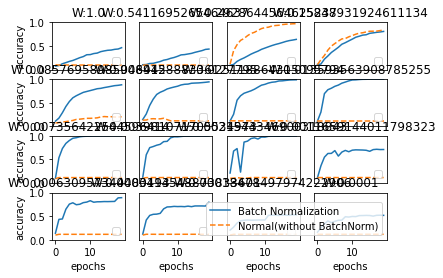

In [15]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


## 6.4. 바른 학습을 위해

#### 오버피팅

오버피팅을 일으켜보기 위해 60,000개인 MNIST 데이터셋의 훈련 데이터 중 300개만 사용하고, 7층 네트워크를 사용해 네트워크의 복잡성을 높인다.

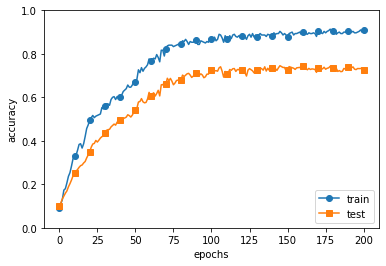

In [17]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

#         print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


#### 드롭아웃

train loss:2.3268414159002346
=== epoch:1, train acc:0.13, test acc:0.1295 ===
train loss:2.3254208722760286
train loss:2.305274567524759
train loss:2.3185800748462886
=== epoch:2, train acc:0.13, test acc:0.1293 ===
train loss:2.323226612925495
train loss:2.2814044801084665
train loss:2.2974142265053583
=== epoch:3, train acc:0.13333333333333333, test acc:0.1288 ===
train loss:2.3004633100816507
train loss:2.307460995178997
train loss:2.2902028756737765
=== epoch:4, train acc:0.13, test acc:0.1274 ===
train loss:2.314935904522145
train loss:2.2962219206543155
train loss:2.292298586699023
=== epoch:5, train acc:0.13, test acc:0.1275 ===
train loss:2.294941593268074
train loss:2.2930857004745833
train loss:2.3116476902104375
=== epoch:6, train acc:0.13333333333333333, test acc:0.1281 ===
train loss:2.302344092973793
train loss:2.327813625239067
train loss:2.30872173612811
=== epoch:7, train acc:0.13333333333333333, test acc:0.1295 ===
train loss:2.278694814964953
train loss:2.2917845603

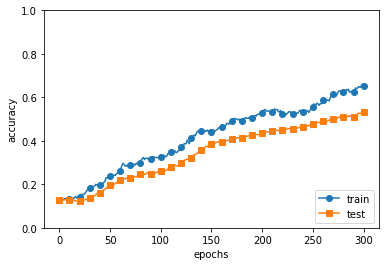

In [18]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()